In this notebook, I did these tasks
1. I tokenized 293 transcripts.
2. I sliced all tokens to 510 (BERT can take only 512 tokens per time)
3. I converted them in to embeddings.
4. I created 3 different types of sentence/word to express 'self-determination'
5. I converted the self-determination examples to embeddings.
6. I visualized them using UMAP.

In [1]:
! pip install transformers

     |████████████████████████████████| 4.0 MB 4.7 MB/s 
     |████████████████████████████████| 596 kB 37.0 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 880 kB 37.5 MB/s 
     |████████████████████████████████| 6.6 MB 46.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.51-py3-none-any.whl size=895170 sha256=54ba0f3107920ad7c6bed03440600de54e9b346423c68f894451afe3fc9a7b8d
  Stored in directory: /root/.cache/pip/wheels/a0/95/bf/f9b021d14dbea2160ac68cbdf606e42e01119e0ba7206a6157
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

from scipy.spatial.distance import cosine

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

# Test to see how Transformers understand question and answer

In [7]:
test = 'Is Soyeon a student at Vanderbilt University?'
test2 = 'Is Soyeon a student at Vanderbilt University? Yes.'
test3 = 'Is Soyeon a student at Vanderbilt University? No.'
test4 = "Soyeon is a student at Vanderbilt University."
test5 = "Soyeon is not a student at Vanderbilt University."
test6 = "Yes."
test7 = "No."
test8 = 'Speaker 1: Is Soyeon a student at Vanderbilt University? Speaker 2: Yes'

In [8]:
def sentence_embedding(text):
  marked_text = "[CLS] " + text + " [SEP]"
  tokenized_text = tokenizer.tokenize(marked_text)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1] * len(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])

  with torch.no_grad():

      outputs = model(tokens_tensor, segments_tensors)

      # Evaluating the model will return a different number of objects based on 
      # how it's  configured in the `from_pretrained` call earlier. In this case, 
      # becase we set `output_hidden_states = True`, the third item will be the 
      # hidden states from all layers. See the documentation for more details:
      # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
      hidden_states = outputs[2]

  hidden_states = outputs[2]
  token_embeddings = torch.stack(hidden_states, dim=0)
  token_embeddings = torch.squeeze(token_embeddings, dim=1)
  token_embeddings = token_embeddings.permute(1,0,2)

  # `token_vecs` is a tensor with shape [22 x 768]
  token_vecs = hidden_states[-2][0]

  # Calculate the average of all 22 token vectors.
  sentence_embedding = torch.mean(token_vecs, dim=0)

  return sentence_embedding

In [9]:
test_emb = sentence_embedding(test)
test_emb2 = sentence_embedding(test2)
test_emb3 = sentence_embedding(test3)
test_emb4 = sentence_embedding(test4)
test_emb5 = sentence_embedding(test5)
test_emb6 = sentence_embedding(test6)
test_emb7 = sentence_embedding(test7)
test_emb8 = sentence_embedding(test8)

In [10]:
# test = 'Is Soyeon a student at Vanderbilt University?'
# test2 = 'Is Soyeon a student at Vanderbilt University? Yes.'
# test3 = 'Is Soyeon a student at Vanderbilt University? No.'
# test4 = "Soyeon is a student at Vanderbilt University."
# test5 = "Soyeon is not a student at Vanderbilt University."
# test6 = "Yes."
# test7 = "No."
# test8 = 'Speaker 1: Is Soyeon a student at Vanderbilt University? Speaker 2: Yes'

# Convert transcripts to embeddings

In [16]:
import pandas as pd

In [77]:
df = pd.read_csv('/content/drive/MyDrive/Capstone Design/data/processed_data/processed_data.csv')

In [78]:
df.head()

,Unnamed: 0,participant,file_name,speaker,speech,date,transcript_filepath,year,month,day
0,0,2039,2039_parent_11.04.2021.docx,Speaker 1:,"Has been involved in, I would love to hear abo...",2021-11-4,/content/drive/MyDrive/Capstone Design/data/fi...,2021,11,4
1,1,2039,2039_parent_11.04.2021.docx,Speaker 2:,"Correct. No, he's post high school.",2021-11-4,/content/drive/MyDrive/Capstone Design/data/fi...,2021,11,4
2,2,2039,2039_parent_11.04.2021.docx,Speaker 1:,Just like to confirm. So did Adrian exit the s...,2021-11-4,/content/drive/MyDrive/Capstone Design/data/fi...,2021,11,4
3,3,2039,2039_parent_11.04.2021.docx,Speaker 2:,"No, he was already out.",2021-11-4,/content/drive/MyDrive/Capstone Design/data/fi...,2021,11,4
4,4,2039,2039_parent_11.04.2021.docx,Speaker 1:,"Okay. So for this section, I'm going to ask yo...",2021-11-4,/content/drive/MyDrive/Capstone Design/data/fi...,2021,11,4


In [79]:
df = df.drop('Unnamed: 0', axis = 1)
df = df[~df['speech'].isna()]

In [80]:
df['speaker_speech'] = df['speaker'] + ' ' + df['speech']

In [81]:
df.head()

,participant,file_name,speaker,speech,date,transcript_filepath,year,month,day,speaker_speech
0,2039,2039_parent_11.04.2021.docx,Speaker 1:,"Has been involved in, I would love to hear abo...",2021-11-4,/content/drive/MyDrive/Capstone Design/data/fi...,2021,11,4,"Speaker 1: Has been involved in, I would love ..."
1,2039,2039_parent_11.04.2021.docx,Speaker 2:,"Correct. No, he's post high school.",2021-11-4,/content/drive/MyDrive/Capstone Design/data/fi...,2021,11,4,"Speaker 2: Correct. No, he's post high school."
2,2039,2039_parent_11.04.2021.docx,Speaker 1:,Just like to confirm. So did Adrian exit the s...,2021-11-4,/content/drive/MyDrive/Capstone Design/data/fi...,2021,11,4,Speaker 1: Just like to confirm. So did Adrian...
3,2039,2039_parent_11.04.2021.docx,Speaker 2:,"No, he was already out.",2021-11-4,/content/drive/MyDrive/Capstone Design/data/fi...,2021,11,4,"Speaker 2: No, he was already out."
4,2039,2039_parent_11.04.2021.docx,Speaker 1:,"Okay. So for this section, I'm going to ask yo...",2021-11-4,/content/drive/MyDrive/Capstone Design/data/fi...,2021,11,4,"Speaker 1: Okay. So for this section, I'm goin..."


In [82]:
filename = df['file_name'].unique()

In [83]:
chunk_list = []
for i in range(len(filename)):
  temp = df[df['file_name'] == filename[i]]
  chunk = ' '.join(temp['speech'])
  chunk_list.append(chunk)

In [84]:
chunk_list[0]

'Has been involved in, I would love to hear about what he\'s doing now. So as of the last interview,  was not in high school. That is still correct? Correct. No, he\'s post high school. Just like to confirm. So did Adrian exit the school system since we last spoke in May? No, he was already out. Okay. So for this section, I\'m going to ask you about academic programs, employment, and volunteering activities that Adrian attended since May 12th of this year in 2021. So first, I\'d like to get an idea of how Adrian usually spends his time. We\'re going to talk about the activities that he participates in during a typical week. So what does a typical week look like for Adrian? How has he been spending his time? Well, I\'m going guess on some of this, because I\'m at work during the day. So I\'m not sure what he does when I\'m at work. But from my understanding, what he does when I\'m at work is, he\'ll work out. I don\'t think it\'s as consistent as he says. No, I shouldn\'t say that. He i

In [85]:
sp_chunk_list = []
for i in range(len(filename)):
  temp = df[df['file_name'] == filename[i]]
  chunk = ' '.join(temp['speaker_speech'])
  sp_chunk_list.append(chunk)

In [86]:
sp_chunk_list[:5]

['Speaker 1: Has been involved in, I would love to hear about what he\'s doing now. So as of the last interview,  was not in high school. That is still correct? Speaker 2: Correct. No, he\'s post high school. Speaker 1: Just like to confirm. So did Adrian exit the school system since we last spoke in May? Speaker 2: No, he was already out. Speaker 1: Okay. So for this section, I\'m going to ask you about academic programs, employment, and volunteering activities that Adrian attended since May 12th of this year in 2021. So first, I\'d like to get an idea of how Adrian usually spends his time. We\'re going to talk about the activities that he participates in during a typical week. So what does a typical week look like for Adrian? How has he been spending his time? Speaker 2: Well, I\'m going guess on some of this, because I\'m at work during the day. So I\'m not sure what he does when I\'m at work. But from my understanding, what he does when I\'m at work is, he\'ll work out. I don\'t th

In [87]:
data = {'filename': filename, 'speech': chunk_list}
no_sp_df = pd.DataFrame(data)

In [88]:
no_sp_df

,filename,speech
0,2039_parent_11.04.2021.docx,"Has been involved in, I would love to hear abo..."
1,2033_VocIndex-and-SA_07.09.2020.docx,"... wash, that's probably one of the more... H..."
2,2035_GAS-and-VocIndex_06.18.2020.docx,"No problem. Great. Hey, Molly. That was quick...."
3,2040_VocIndex_06.19.2020.docx,"Okay. I'm guessing not as well, because usuall..."
4,2034_GAS_Voc_SA_05.18.2020.docx,That maybe you're not getting now. So hold on ...
...,...,...
288,1060_voc index_06.17.2021.docx,No problem. I was afraid when she said sometim...
289,1059_VocParent_VocYouth_07.23.2020.docx,"And then, we can speak with him. Okay. And so,..."
290,3008_T3-12-mo-Parent-and-Youth_11.13.2021.docx,So she has to do contact tracing and stuff sti...
291,3009_ Parent 12-Month Follow Up Interview_10.2...,... develop a more integrated social and emoti...


In [89]:
data = {'filename': filename, 'speech': sp_chunk_list}
sp_df = pd.DataFrame(data)

In [90]:
sp_df.head()

,filename,speech
0,2039_parent_11.04.2021.docx,"Speaker 1: Has been involved in, I would love ..."
1,2033_VocIndex-and-SA_07.09.2020.docx,"Speaker 1: ... wash, that's probably one of th..."
2,2035_GAS-and-VocIndex_06.18.2020.docx,"Speaker 1: No problem. Speaker 2: Great. Hey, ..."
3,2040_VocIndex_06.19.2020.docx,"Speaker 1: Okay. I'm guessing not as well, bec..."
4,2034_GAS_Voc_SA_05.18.2020.docx,Speaker 1: That maybe you're not getting now. ...


In [91]:
import numpy as np

In [92]:
test = sp_chunk_list[0]

In [93]:
tokenized_text = tokenizer.tokenize(test)

In [94]:
chunked_list = list()
chunk_size = 510
for i in range(0, len(tokenized_text), chunk_size):
  chunked_list.append(tokenized_text[i:i+chunk_size])

In [95]:
def one_sentence_embedding(text):
  marked_text = "[CLS] " + text + " [SEP]"
  tokenized_text = tokenizer.tokenize(marked_text)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1] * len(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])

  with torch.no_grad():

      outputs = model(tokens_tensor, segments_tensors)

      # Evaluating the model will return a different number of objects based on 
      # how it's  configured in the `from_pretrained` call earlier. In this case, 
      # becase we set `output_hidden_states = True`, the third item will be the 
      # hidden states from all layers. See the documentation for more details:
      # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
      hidden_states = outputs[2]

  hidden_states = outputs[2]
  token_embeddings = torch.stack(hidden_states, dim=0)
  token_embeddings = torch.squeeze(token_embeddings, dim=1)
  token_embeddings = token_embeddings.permute(1,0,2)

  # `token_vecs` is a tensor with shape [22 x 768]
  token_vecs = hidden_states[-2][0]

  # Calculate the average of all 22 token vectors.
  sentence_embedding = torch.mean(token_vecs, dim=0)
  sentence_embedding = sentence_embedding.tolist()
  return sentence_embedding

In [96]:
def sentence_embedding(text):
  indexed_tokens = tokenizer.convert_tokens_to_ids(text)
  segments_ids = [1] * len(text)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])

  with torch.no_grad():

      outputs = model(tokens_tensor, segments_tensors)

      # Evaluating the model will return a different number of objects based on 
      # how it's  configured in the `from_pretrained` call earlier. In this case, 
      # becase we set `output_hidden_states = True`, the third item will be the 
      # hidden states from all layers. See the documentation for more details:
      # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
      hidden_states = outputs[2]

  hidden_states = outputs[2]
  token_embeddings = torch.stack(hidden_states, dim=0)
  token_embeddings = torch.squeeze(token_embeddings, dim=1)
  token_embeddings = token_embeddings.permute(1,0,2)

  # `token_vecs` is a tensor with shape [22 x 768]
  token_vecs = hidden_states[-2][0]

  # Calculate the average of all 22 token vectors.
  sentence_embedding = torch.mean(token_vecs, dim=0)
  sentence_embedding = sentence_embedding.tolist()
  return sentence_embedding

In [97]:
def get_embedding(row):
  tokenized_text = tokenizer.tokenize(row)
  chunked_list = list()
  chunk_size = 510
  for i in range(0, len(tokenized_text), chunk_size):
    chunked_list.append(tokenized_text[i:i+chunk_size])

  result_list = []
  for i in range(len(chunked_list)):
    text = chunked_list[i]
    text.insert(0, '[CLS]')
    text.append('[SEP]')
    emb = sentence_embedding(text)
    result_list.append(emb)

  data = np.array(result_list)
  fn = np.average(data, axis = 0)
  print('finish' + str(row))
  return fn

In [ ]:
sp_df['embedding'] = sp_df['speech'].apply(lambda x: get_embedding(x))

In [99]:
no_sp_df['embedding'] = no_sp_df['speech'].apply(lambda x: get_embedding(x))

finishHas been involved in, I would love to hear about what he's doing now. So as of the last interview,  was not in high school. That is still correct? Correct. No, he's post high school. Just like to confirm. So did Adrian exit the school system since we last spoke in May? No, he was already out. Okay. So for this section, I'm going to ask you about academic programs, employment, and volunteering activities that Adrian attended since May 12th of this year in 2021. So first, I'd like to get an idea of how Adrian usually spends his time. We're going to talk about the activities that he participates in during a typical week. So what does a typical week look like for Adrian? How has he been spending his time? Well, I'm going guess on some of this, because I'm at work during the day. So I'm not sure what he does when I'm at work. But from my understanding, what he does when I'm at work is, he'll work out. I don't think it's as consistent as he says. No, I shouldn't say that. He is very tr

In [ ]:
#sp_df.to_csv('/content/drive/MyDrive/Capstone Design/data/processed_data/sp_bert_emb.csv')

In [ ]:
#no_sp_df.to_csv('/content/drive/MyDrive/Capstone Design/data/processed_data/no_sp_bert_emb.csv')

In [33]:
sp_df.head()

,filename,speech,embedding
0,2039_parent_11.04.2021.docx,"Speaker 1: Has been involved in, I would love ...",[ 2.96977113e-02 -1.90410142e-02 1.79058180e-...
1,2033_VocIndex-and-SA_07.09.2020.docx,"Speaker 1: ... wash, that's probably one of th...",[-3.33189294e-02 -2.33957544e-03 2.71902289e-...
2,2035_GAS-and-VocIndex_06.18.2020.docx,"Speaker 1: No problem. Speaker 2: Great. Hey, ...",[ 3.94090873e-02 2.09532715e-02 1.14781392e-...
3,2040_VocIndex_06.19.2020.docx,"Speaker 1: Okay. I'm guessing not as well, bec...",[-9.38702676e-02 9.79618879e-02 5.54792632e-...
4,2034_GAS_Voc_SA_05.18.2020.docx,Speaker 1: That maybe you're not getting now. ...,[ 4.45095183e-02 -7.91764669e-02 1.47083968e-...


In [100]:
sp_df = sp_df.rename({'embedding': "sp_embedding", "speech": "sp_speech"}, axis = 1)

In [101]:
no_sp_df.head()

,filename,speech,embedding
0,2039_parent_11.04.2021.docx,"Has been involved in, I would love to hear abo...","[0.06528732925653458, 0.025580383837223053, 0...."
1,2033_VocIndex-and-SA_07.09.2020.docx,"... wash, that's probably one of the more... H...","[0.13536084443330765, 0.0085732894949615, 0.04..."
2,2035_GAS-and-VocIndex_06.18.2020.docx,"No problem. Great. Hey, Molly. That was quick....","[0.07731928676366806, -0.004143821075558662, 0..."
3,2040_VocIndex_06.19.2020.docx,"Okay. I'm guessing not as well, because usuall...","[0.027029703371226788, 0.08301078155636787, 0...."
4,2034_GAS_Voc_SA_05.18.2020.docx,That maybe you're not getting now. So hold on ...,"[0.06146159581840038, -0.037550002336502075, 0..."


In [102]:
no_sp_df = no_sp_df.rename({'speech':'no_sp_speech', 'embedding': 'no_sp_embedding'}, axis = 1)

In [103]:
merge_df = pd.merge(sp_df, no_sp_df, on='filename')

In [104]:
merge_df.head()

,filename,sp_speech,no_sp_speech,no_sp_embedding
0,2039_parent_11.04.2021.docx,"Speaker 1: Has been involved in, I would love ...","Has been involved in, I would love to hear abo...","[0.06528732925653458, 0.025580383837223053, 0...."
1,2033_VocIndex-and-SA_07.09.2020.docx,"Speaker 1: ... wash, that's probably one of th...","... wash, that's probably one of the more... H...","[0.13536084443330765, 0.0085732894949615, 0.04..."
2,2035_GAS-and-VocIndex_06.18.2020.docx,"Speaker 1: No problem. Speaker 2: Great. Hey, ...","No problem. Great. Hey, Molly. That was quick....","[0.07731928676366806, -0.004143821075558662, 0..."
3,2040_VocIndex_06.19.2020.docx,"Speaker 1: Okay. I'm guessing not as well, bec...","Okay. I'm guessing not as well, because usuall...","[0.027029703371226788, 0.08301078155636787, 0...."
4,2034_GAS_Voc_SA_05.18.2020.docx,Speaker 1: That maybe you're not getting now. ...,That maybe you're not getting now. So hold on ...,"[0.06146159581840038, -0.037550002336502075, 0..."


In [ ]:
from numpy import dot
from numpy.linalg import norm
result = []
for i in range(merge_df.shape[0]): 
  sp_em = merge_df['sp_embedding'][i]
  no_sp_em = merge_df['no_sp_embedding'][i]
  final = dot(sp_em, no_sp_em)/(norm(sp_em)*norm(no_sp_em))
  result.append(final)

In [ ]:
merge_df['cosine'] = result

In [ ]:
merge_df

,filename,sp_speech,sp_embedding,no_sp_speech,no_sp_embedding,cosine
0,2039_parent_11.04.2021.docx,"Speaker 1: Has been involved in, I would love ...","[0.029697711269060772, -0.01904101421435674, 0...","Has been involved in, I would love to hear abo...","[0.06528732925653458, 0.025580383837223053, 0....",0.984115
1,2033_VocIndex-and-SA_07.09.2020.docx,"Speaker 1: ... wash, that's probably one of th...","[-0.03331892937421799, -0.0023395754396915436,...","... wash, that's probably one of the more... H...","[0.13536084443330765, 0.0085732894949615, 0.04...",0.987756
2,2035_GAS-and-VocIndex_06.18.2020.docx,"Speaker 1: No problem. Speaker 2: Great. Hey, ...","[0.03940908734997114, 0.02095327153801918, 0.1...","No problem. Great. Hey, Molly. That was quick....","[0.07731928676366806, -0.004143821075558662, 0...",0.986645
3,2040_VocIndex_06.19.2020.docx,"Speaker 1: Okay. I'm guessing not as well, bec...","[-0.09387026755855633, 0.09796188786052741, 0....","Okay. I'm guessing not as well, because usuall...","[0.027029703371226788, 0.08301078155636787, 0....",0.994014
4,2034_GAS_Voc_SA_05.18.2020.docx,Speaker 1: That maybe you're not getting now. ...,"[0.04450951827069124, -0.07917646691203117, 0....",That maybe you're not getting now. So hold on ...,"[0.06146159581840038, -0.037550002336502075, 0...",0.976411
...,...,...,...,...,...,...
288,1060_voc index_06.17.2021.docx,Speaker 1: No problem. I was afraid when she s...,"[-0.10190922270218532, 0.011057732005914053, 0...",No problem. I was afraid when she said sometim...,"[0.011633516910175482, 0.0014058779925107956, ...",0.994531
289,1059_VocParent_VocYouth_07.23.2020.docx,"Interviewer: And then, we can speak with him. ...","[-0.031009119749069215, -0.10582957118749618, ...","And then, we can speak with him. Okay. And so,...","[0.1314499443396926, -0.030817768536508083, 0....",0.980368
290,3008_T3-12-mo-Parent-and-Youth_11.13.2021.docx,Speaker 1 : So she has to do contact tracing a...,"[-0.09500049632818748, 0.05092362190286318, 0....",So she has to do contact tracing and stuff sti...,"[0.10457069675127666, -0.004068486392498016, 0...",0.982491
291,3009_ Parent 12-Month Follow Up Interview_10.2...,Speaker 2 : ... develop a more integrated soci...,"[-0.254646224634988, -0.1164369907762323, 0.18...",... develop a more integrated social and emoti...,"[-0.15077812721331915, -0.07525591800610225, 0...",0.989525


# Convert self-determination into Embeddings

In [105]:
definition = 'dispositional characteristic manifested as acting as the causal agent in one’s life. Self-determined people act in service to freely chosen goals. Self-determined actions function to enable a person to be the causal agent is his or her life.'

In [106]:
choice_make_sit = 'When presented with two or more possibilities, a person is able to consider each of the possibilities and identify the one possibility that is best. They are provided with several options and are able choose the option that is best for them.'
decision_make_sit = 'A person is able to gather information and use that information to decide how to proceed in a certain situation.'
prob_sov_sit = 'A person is able to identify an area of concern, define the problem, determine the cause of the problem, and take steps to address the problem.'
goal_set_sit = 'A person is able to identify a specific thing that they would like to achieve over a particular period of time.'
goal_att_sit = 'A person is able to carry out the steps necessary to actualize a goal that they have set for themselves or that someone else has set for them.'
self_advocacy_sit = 'Someone who is able to speak up for themselves to ensure their rights are upheld or to ensure that a particular situation is carried out in a way that does not disadvantage them.'
self_mng_sit = 'A person has the skills needed to control their behavior in order to obtain long-term benefits.'
self_aware_sit = 'A person understands different aspects of themselves, such as their strengths, preferences, interests, and needs.'

In [107]:
def_emb = one_sentence_embedding(definition)

In [108]:
word_emb = one_sentence_embedding('self-determined')

In [109]:
choice_make_sit_emb = one_sentence_embedding(choice_make_sit)
decision_make_sit_emb = one_sentence_embedding(decision_make_sit)
prob_sov_sit_emb = one_sentence_embedding(prob_sov_sit)
goal_set_sit_emb = one_sentence_embedding(goal_set_sit)
goal_att_sit_emb = one_sentence_embedding(goal_att_sit)
self_advocacy_sit_emb = one_sentence_embedding(self_advocacy_sit)
self_mng_sit_emb = one_sentence_embedding(self_mng_sit)
self_aware_sit_emb = one_sentence_embedding(self_aware_sit)

In [110]:
from numpy import dot
from numpy.linalg import norm
result = []
for i in range(merge_df.shape[0]): 
  no_sp_em = merge_df['no_sp_embedding'][i]
  final = dot(def_emb, no_sp_em)/(norm(def_emb)*norm(no_sp_em))
  result.append(final)

In [111]:
merge_df['cosine_def'] = result

In [112]:
merge_df

,filename,sp_speech,no_sp_speech,no_sp_embedding,cosine_def
0,2039_parent_11.04.2021.docx,"Speaker 1: Has been involved in, I would love ...","Has been involved in, I would love to hear abo...","[0.06528732925653458, 0.025580383837223053, 0....",0.768124
1,2033_VocIndex-and-SA_07.09.2020.docx,"Speaker 1: ... wash, that's probably one of th...","... wash, that's probably one of the more... H...","[0.13536084443330765, 0.0085732894949615, 0.04...",0.742862
2,2035_GAS-and-VocIndex_06.18.2020.docx,"Speaker 1: No problem. Speaker 2: Great. Hey, ...","No problem. Great. Hey, Molly. That was quick....","[0.07731928676366806, -0.004143821075558662, 0...",0.745241
3,2040_VocIndex_06.19.2020.docx,"Speaker 1: Okay. I'm guessing not as well, bec...","Okay. I'm guessing not as well, because usuall...","[0.027029703371226788, 0.08301078155636787, 0....",0.765937
4,2034_GAS_Voc_SA_05.18.2020.docx,Speaker 1: That maybe you're not getting now. ...,That maybe you're not getting now. So hold on ...,"[0.06146159581840038, -0.037550002336502075, 0...",0.731664
...,...,...,...,...,...
288,1060_voc index_06.17.2021.docx,Speaker 1: No problem. I was afraid when she s...,No problem. I was afraid when she said sometim...,"[0.011633516910175482, 0.0014058779925107956, ...",0.775040
289,1059_VocParent_VocYouth_07.23.2020.docx,"Interviewer: And then, we can speak with him. ...","And then, we can speak with him. Okay. And so,...","[0.1314499443396926, -0.030817768536508083, 0....",0.734330
290,3008_T3-12-mo-Parent-and-Youth_11.13.2021.docx,Speaker 1 : So she has to do contact tracing a...,So she has to do contact tracing and stuff sti...,"[0.10457069675127666, -0.004068486392498016, 0...",0.745488
291,3009_ Parent 12-Month Follow Up Interview_10.2...,Speaker 2 : ... develop a more integrated soci...,... develop a more integrated social and emoti...,"[-0.15077812721331915, -0.07525591800610225, 0...",0.789392


In [114]:
merge_df = merge_df.sort_values('cosine_def', ascending = False)

In [115]:
merge_df.to_csv('/content/drive/MyDrive/Capstone Design/data/processed_data/no_sp_bert_def_cosine.csv')

In [116]:
merge_df

,filename,sp_speech,no_sp_speech,no_sp_embedding,cosine_def
167,3027_T3-12-month-Parent-and-Youth_11.04.2021.docx,Speaker 1 : It takes my computer a second to k...,It takes my computer a second to kind of think...,"[-0.0437611099332571, -0.012971162796020508, 0...",0.797771
258,1031_voc index_12.20.2021.docx,Interviewer: ... still in high school. Speaker...,... still in high school. Mm-hmm . And we went...,"[-0.20268377661705017, 0.06939678639173508, 0....",0.795656
291,3009_ Parent 12-Month Follow Up Interview_10.2...,Speaker 2 : ... develop a more integrated soci...,... develop a more integrated social and emoti...,"[-0.15077812721331915, -0.07525591800610225, 0...",0.789392
154,3002_Parent_12-Month-Interview_11.17.2021.docx,Speaker 1 : The activities Cyrus has been invo...,"The activities Cyrus has been involved in, jus...","[-0.005376491618032257, -0.0019986132780710855...",0.788043
132,2057_parent_11.01.2021.docx,Speaker 1 : Graduated years ago. Interviewer :...,Graduated years ago. Yeah. Did Ivan exit schoo...,"[0.039648761972784996, 0.007530417293310165, 0...",0.786208
...,...,...,...,...,...
209,1013_VocIndexYouth_01.28.2020.docx,Interviewer: Your dad was telling us about Nex...,Your dad was telling us about Next Steps that ...,"[0.08381874114274979, -0.24642515182495117, 0....",0.693591
72,1043_voc index_youth_12.16.2021.docx,"Speaker 1: ... about what you do with Unboxed,...","... about what you do with Unboxed, and I just...","[0.045393168926239014, -0.07737671583890915, 0...",0.687812
36,1065_voc index_youth_11.01.2021.docx,Interviewer: So your mom was telling me about ...,So your mom was telling me about volunteering ...,"[0.333617240190506, -0.2161472737789154, 0.221...",0.686623
49,1058_Voc_Service_08.04.2020.docx,Speaker 1: Worked during high school? Speaker ...,Worked during high school? No. And what about ...,"[0.41602402925491333, -0.18316768109798431, -0...",0.680236


# UMAP visualization

In [ ]:
test = merge_df['no_sp_embedding'].to_frame()

In [ ]:
test.head()

,no_sp_embedding
0,"[0.06528732925653458, 0.025580383837223053, 0...."
1,"[0.13536084443330765, 0.0085732894949615, 0.04..."
2,"[0.07731928676366806, -0.004143821075558662, 0..."
3,"[0.027029703371226788, 0.08301078155636787, 0...."
4,"[0.06146159581840038, -0.037550002336502075, 0..."


In [ ]:
test = test.no_sp_embedding.apply(pd.Series)

In [ ]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.065287,0.025580,0.122420,-0.065399,0.484347,-0.117218,-0.099787,0.747030,-0.059363,-0.155838,...,-0.487998,-0.243178,0.237352,0.026969,-0.176885,0.057142,-0.145180,-0.234448,0.320547,-0.160393
1,0.135361,0.008573,0.045354,-0.188340,0.523197,0.020245,-0.246476,1.061914,-0.200180,-0.001393,...,-0.519153,-0.162791,0.300163,-0.169146,-0.113667,0.011936,-0.340532,-0.277960,0.388296,-0.072789
2,0.077319,-0.004144,0.143816,-0.103315,0.497459,-0.120177,-0.152117,0.841237,-0.123489,-0.187694,...,-0.481598,-0.212483,0.298908,-0.092866,-0.168283,0.033790,-0.315616,-0.245781,0.268886,-0.223485
3,0.027030,0.083011,0.111576,-0.079268,0.495282,-0.020970,-0.164302,0.798118,-0.146146,-0.208635,...,-0.643604,-0.271504,0.381249,-0.052317,-0.191265,0.111314,-0.232947,-0.302560,0.303164,-0.216484
4,0.061462,-0.037550,0.059881,-0.215088,0.634744,-0.134813,-0.198874,0.970225,-0.223366,-0.146606,...,-0.534524,-0.191682,0.234819,-0.014759,-0.190741,0.181047,-0.337060,-0.169331,0.337397,-0.236385


In [ ]:
test2 = merge_df['sp_embedding'].to_frame()

In [ ]:
test2 = test2.sp_embedding.apply(pd.Series)

In [ ]:
test2['category'] = 'no_speaker'

In [ ]:
test['category'] = 'speaker'

In [ ]:
test_umap = pd.concat([test, test2])

In [ ]:
! pip install umap

  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=280984814db2c5203f243b544c14032bbd1f0b96996a98d9812d20d7d55ab3df
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap


In [ ]:
! pip install umap-learn[plot]

     |████████████████████████████████| 88 kB 2.1 MB/s 
     |████████████████████████████████| 1.1 MB 8.3 MB/s 
     |████████████████████████████████| 18.2 MB 18.0 MB/s 
     |████████████████████████████████| 76 kB 3.1 MB/s 
     |████████████████████████████████| 837 kB 37.5 MB/s 
     |████████████████████████████████| 136 kB 39.0 MB/s 
     |████████████████████████████████| 830 kB 34.2 MB/s 
     |████████████████████████████████| 822 kB 39.8 MB/s 
     |████████████████████████████████| 802 kB 37.1 MB/s 
     |████████████████████████████████| 802 kB 37.3 MB/s 
     |████████████████████████████████| 793 kB 29.9 MB/s 
     |████████████████████████████████| 793 kB 39.8 MB/s 
     |████████████████████████████████| 791 kB 39.3 MB/s 
     |████████████████████████████████| 786 kB 35.3 MB/s 
     |████████████████████████████████| 779 kB 10.7 MB/s 
     |████████████████████████████████| 778 kB 11.5 MB/s 
     |████████████████████████████████| 776 kB 56.8 MB/s 
     |████████████

In [ ]:
import umap
import umap.umap_ as umap
import umap.plot

import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer

In [ ]:
import umap.umap_ as umap
X, y = test_umap.drop("category", axis=1), test_umap[["category"]].values.flatten()

pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

y_encoded = pd.factorize(y)[0]

manifold = umap.UMAP().fit(X, y_encoded)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


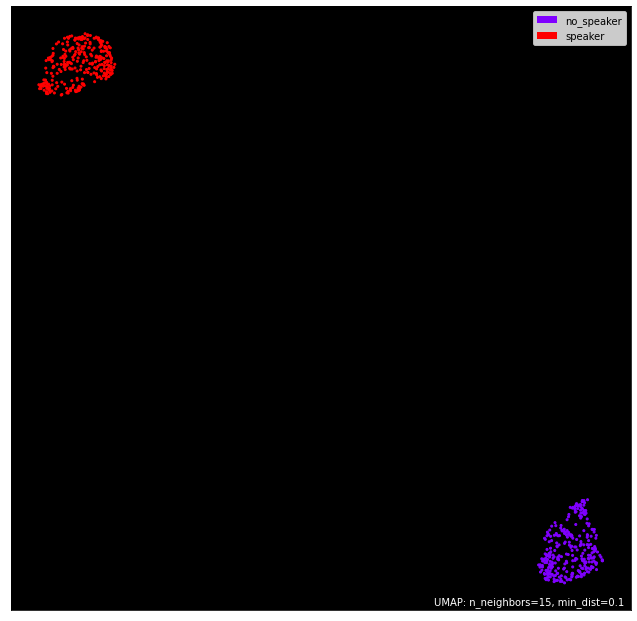

In [ ]:
import umap.plot
umap.plot.points(manifold, labels=y, theme="fire");

In [ ]:
word_emb.append('word')

In [ ]:
test_umap.loc[len(test_umap)] = word_emb

In [ ]:
import umap.umap_ as umap
X, y = test_umap.drop("category", axis=1), test_umap[["category"]].values.flatten()

pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

y_encoded = pd.factorize(y)[0]

manifold = umap.UMAP().fit(X, y_encoded)

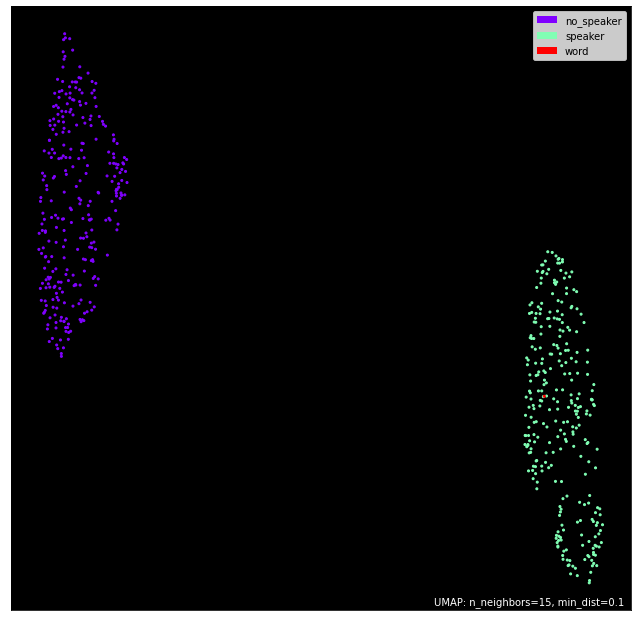

In [ ]:
import umap.plot
umap.plot.points(manifold, labels=y, theme="fire");

In [ ]:
def_emb.append('definition')

In [ ]:
choice_make_sit_emb.append('choice_make_sit')
decision_make_sit_emb.append('decision_make_sit')
prob_sov_sit_emb.append('prob_sov_sit')
goal_set_sit_emb.append('goal_set_sit')
goal_att_sit_emb.append('goal_att_sit')
self_advocacy_sit_emb.append('self_advocacy_sit')
self_mng_sit_emb.append('self_mng_sit')
self_aware_sit_emb.append('self_aware_sit')

In [ ]:
test_umap.loc[len(test_umap)] = def_emb
test_umap.loc[len(test_umap)] = choice_make_sit_emb
test_umap.loc[len(test_umap)] = decision_make_sit_emb
test_umap.loc[len(test_umap)] = prob_sov_sit_emb
test_umap.loc[len(test_umap)] = goal_set_sit_emb
test_umap.loc[len(test_umap)] = goal_att_sit_emb
test_umap.loc[len(test_umap)] = self_advocacy_sit_emb
test_umap.loc[len(test_umap)] = self_mng_sit_emb
test_umap.loc[len(test_umap)] = self_aware_sit_emb

In [ ]:
import umap.umap_ as umap
X, y = test_umap.drop("category", axis=1), test_umap[["category"]].values.flatten()

pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

y_encoded = pd.factorize(y)[0]

manifold = umap.UMAP().fit(X, y_encoded)

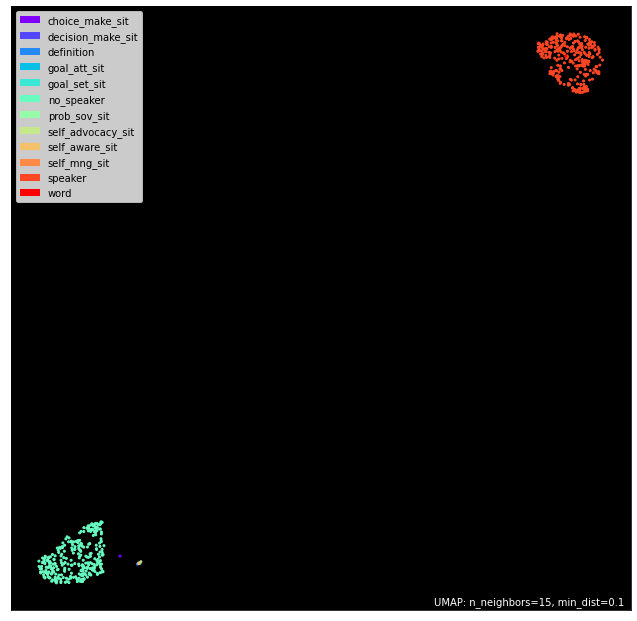

In [ ]:
import umap.plot
umap.plot.points(manifold, labels=y, theme="fire");

In [ ]:
test_umap2 = test_umap[test_umap['category'] != 'choice_make_sit']
test_umap2 = test_umap2[test_umap2['category'] != 'speaker']
test_umap2 = test_umap2[test_umap2['category'] != 'word']
test_umap2 = test_umap2[test_umap2['category'] != 'self_advocacy_sit']

In [ ]:
import umap.umap_ as umap
X, y = test_umap2.drop("category", axis=1), test_umap2[["category"]].values.flatten()

pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

y_encoded = pd.factorize(y)[0]

manifold = umap.UMAP().fit(X, y_encoded)

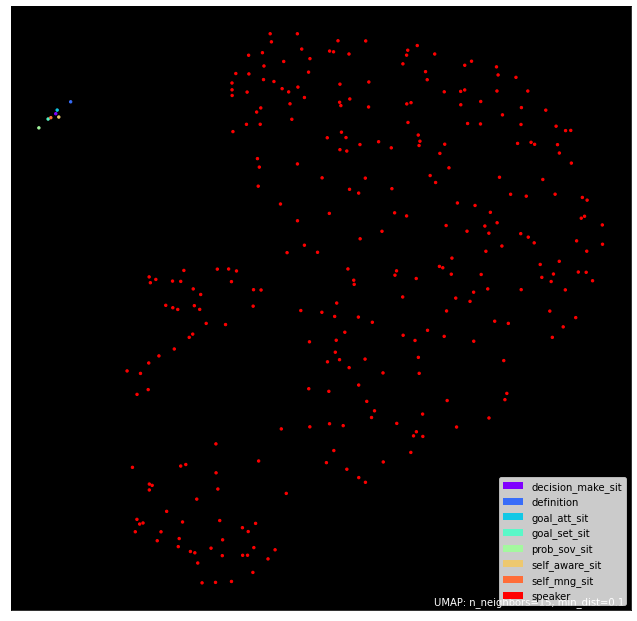

In [ ]:
import umap.plot
umap.plot.points(manifold, labels=y, theme="darkgreen");

In [ ]:
test_umap['category'] == 'speaker'

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,category
0,0.065287,0.025580,0.122420,-0.065399,0.484347,-0.117218,-0.099787,0.747030,-0.059363,-0.155838,...,-0.243178,0.237352,0.026969,-0.176885,0.057142,-0.145180,-0.234448,0.320547,-0.160393,speaker
1,0.135361,0.008573,0.045354,-0.188340,0.523197,0.020245,-0.246476,1.061914,-0.200180,-0.001393,...,-0.162791,0.300163,-0.169146,-0.113667,0.011936,-0.340532,-0.277960,0.388296,-0.072789,speaker
2,0.077319,-0.004144,0.143816,-0.103315,0.497459,-0.120177,-0.152117,0.841237,-0.123489,-0.187694,...,-0.212483,0.298908,-0.092866,-0.168283,0.033790,-0.315616,-0.245781,0.268886,-0.223485,speaker
3,0.027030,0.083011,0.111576,-0.079268,0.495282,-0.020970,-0.164302,0.798118,-0.146146,-0.208635,...,-0.271504,0.381249,-0.052317,-0.191265,0.111314,-0.232947,-0.302560,0.303164,-0.216484,speaker
4,0.061462,-0.037550,0.059881,-0.215088,0.634744,-0.134813,-0.198874,0.970225,-0.223366,-0.146606,...,-0.191682,0.234819,-0.014759,-0.190741,0.181047,-0.337060,-0.169331,0.337397,-0.236385,speaker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,0.108810,0.192889,0.005050,0.102120,0.434378,0.003532,0.461466,0.562023,-0.416818,-0.565567,...,-0.449552,0.696952,0.003175,0.283291,0.276136,0.848190,-0.620408,-0.115319,0.452379,goal_set_sit
592,0.260796,0.494149,-0.270931,-0.204360,0.421940,-0.181080,0.710704,0.394828,-0.273677,-0.609277,...,0.017464,0.376625,-0.076468,0.132751,0.397409,0.644623,-0.446374,0.066360,0.554018,goal_att_sit
593,0.166931,-0.404027,-0.166883,-0.336964,0.325662,-0.241359,0.708440,0.269346,-0.507702,-0.468870,...,-0.214828,0.384525,0.053439,0.335812,-0.105789,0.174141,-0.380571,-0.243413,0.146293,self_advocacy_sit
594,0.098875,-0.120374,-0.184396,0.249755,0.512051,-0.056826,0.313555,0.579711,-0.119563,-0.493277,...,-0.599542,0.178128,0.321602,-0.236175,0.295497,0.154977,-0.695112,-0.373911,0.388995,self_mng_sit


In [ ]:
test_umap3 = test_umap[test_umap['category'] != 'no_speaker']
test_umap3 = test_umap3[test_umap3['category'] != 'choice_make_sit']
test_umap3 = test_umap3[test_umap3['category'] != 'word']
test_umap3 = test_umap3[test_umap3['category'] != 'self_advocacy_sit']

In [ ]:
import umap.umap_ as umap
X, y = test_umap3.drop("category", axis=1), test_umap3[["category"]].values.flatten()

pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

y_encoded = pd.factorize(y)[0]

manifold = umap.UMAP().fit(X, y_encoded)

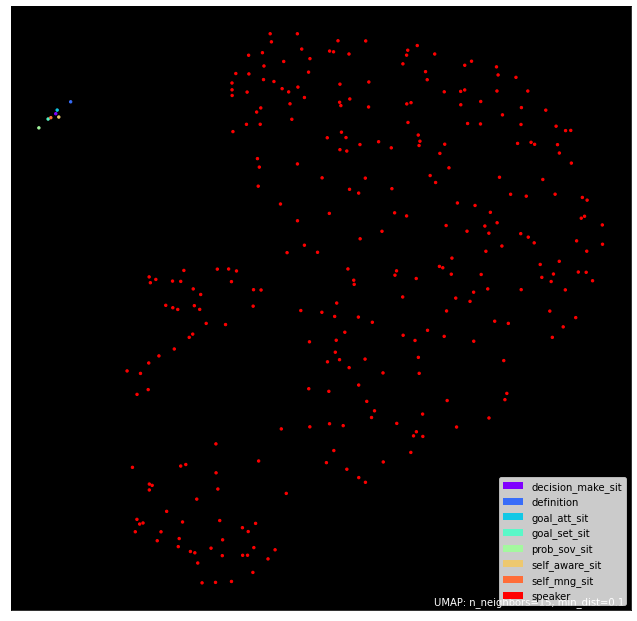

In [ ]:
import umap.plot
umap.plot.points(manifold, labels=y, theme="fire");

In [ ]:
merge_df['cosine']

0      0.984115
1      0.987756
2      0.986645
3      0.994014
4      0.976411
         ...   
288    0.994531
289    0.980368
290    0.982491
291    0.989525
292    0.988128
Name: cosine, Length: 293, dtype: float64

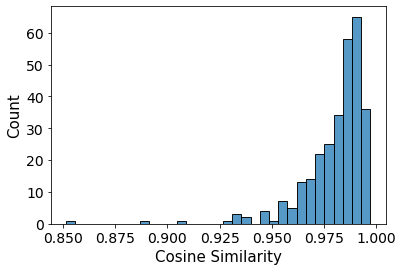

In [ ]:
import seaborn as sns
ax = sns.histplot(data = merge_df, x = 'cosine')
ax.set_xlabel('Cosine Similarity', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=14)
#ax.set_title("Cosine Similarity between transcript embedding with and witout 'Speaker'")

In [ ]:
merge_df.sort_values('cosine')

,filename,sp_speech,sp_embedding,no_sp_speech,no_sp_embedding,cosine,cosine_def
49,1058_Voc_Service_08.04.2020.docx,Speaker 1: Worked during high school? Speaker ...,"[0.043368253856897354, -0.32796916365623474, -...",Worked during high school? No. And what about ...,"[0.41602402925491333, -0.18316768109798431, -0...",0.851412,0.680236
26,2005_voc_SA_01.20.2020.docx,Speaker 1: Okay. All right. It's working. Part...,"[-0.12056840863078833, -0.1051056981086731, 0....",Okay. All right. It's working. Participant 200...,"[-0.14724868535995483, 0.12867451459169388, 0....",0.890305,0.766764
220,1008_voc index_01.07.2021.docx,"Speaker 1: So first, could you describe his hi...","[0.10412704572081566, -0.32724687457084656, 0....","So first, could you describe his high school s...","[0.055344246327877045, -0.10403318703174591, 0...",0.906888,0.718083
54,1056_Voc Index_05.05.2021.docx,Speaker 1: So I'll ask some questions about hi...,"[-0.15982360765337944, -0.0653372872620821, 0....",So I'll ask some questions about his school an...,"[-0.013593975454568863, 0.08131333626806736, 0...",0.930825,0.734180
209,1013_VocIndexYouth_01.28.2020.docx,Interviewer: Your dad was telling us about Nex...,"[-0.0834311693906784, -0.2644895911216736, 0.1...",Your dad was telling us about Next Steps that ...,"[0.08381874114274979, -0.24642515182495117, 0....",0.932745,0.693591
...,...,...,...,...,...,...,...
278,1068_voc index_04.26.2021.docx,Speaker 1: Okay. And so could you briefly desc...,"[-0.018377788364887238, 0.13115712255239487, 0...",Okay. And so could you briefly describe his cu...,"[0.02194380760192871, 0.1495891511440277, 0.14...",0.996187,0.767919
256,1036_VocIndexPar_06.12.2020.docx,Speaker 1: So first about since high school hi...,"[-0.12154088372533972, 0.06818541444160721, 0....","So first about since high school history, if h...","[-0.05975907894952053, 0.06559106064113704, 0....",0.996187,0.761044
226,1005_voc index_par_07.06.2021.docx,"Speaker 1: Okay. And so for this section, I'm ...","[-0.11798923537135124, 0.03382298052310943, -0...","Okay. And so for this section, I'm going to as...","[-0.05695929899811745, 0.05275431573390961, -0...",0.996650,0.773053
128,2056_VocIndex_06.23.2020.docx,Speaker 1 : History. So did he... Has Marshall...,"[0.020299337804317474, -0.08442486822605133, 0...",History. So did he... Has Marshall worked duri...,"[0.06946781588097413, -0.10068960363666217, 0....",0.996756,0.766309


In [ ]:
test_umap4 = test_umap[(test_umap['category'] == 'no_speaker') | (test_umap['category'] == 'speaker')]

In [ ]:
test_umap4

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,category
0,0.065287,0.025580,0.122420,-0.065399,0.484347,-0.117218,-0.099787,0.747030,-0.059363,-0.155838,...,-0.243178,0.237352,0.026969,-0.176885,0.057142,-0.145180,-0.234448,0.320547,-0.160393,speaker
1,0.135361,0.008573,0.045354,-0.188340,0.523197,0.020245,-0.246476,1.061914,-0.200180,-0.001393,...,-0.162791,0.300163,-0.169146,-0.113667,0.011936,-0.340532,-0.277960,0.388296,-0.072789,speaker
2,0.077319,-0.004144,0.143816,-0.103315,0.497459,-0.120177,-0.152117,0.841237,-0.123489,-0.187694,...,-0.212483,0.298908,-0.092866,-0.168283,0.033790,-0.315616,-0.245781,0.268886,-0.223485,speaker
3,0.027030,0.083011,0.111576,-0.079268,0.495282,-0.020970,-0.164302,0.798118,-0.146146,-0.208635,...,-0.271504,0.381249,-0.052317,-0.191265,0.111314,-0.232947,-0.302560,0.303164,-0.216484,speaker
4,0.061462,-0.037550,0.059881,-0.215088,0.634744,-0.134813,-0.198874,0.970225,-0.223366,-0.146606,...,-0.191682,0.234819,-0.014759,-0.190741,0.181047,-0.337060,-0.169331,0.337397,-0.236385,speaker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,-0.101909,0.011058,0.015282,-0.125379,0.306206,0.015167,-0.073769,0.756564,-0.174289,-0.050792,...,-0.329313,0.259047,-0.090866,-0.225138,-0.097095,-0.187135,-0.290315,0.344475,-0.035027,no_speaker
289,-0.031009,-0.105830,0.134961,-0.184363,0.272707,-0.050858,-0.172715,0.830295,-0.019473,-0.022493,...,-0.315447,0.161774,-0.195371,-0.146674,0.135366,-0.299726,-0.132128,0.355939,-0.068881,no_speaker
290,-0.095000,0.050924,0.096244,-0.077082,0.487821,-0.089788,-0.112632,0.811900,-0.137325,-0.103204,...,-0.300091,0.207271,-0.052037,-0.122779,0.004305,-0.221182,-0.166421,0.277391,-0.240525,no_speaker
291,-0.254646,-0.116437,0.181517,-0.166511,0.289510,-0.071155,0.010748,0.568574,-0.112760,-0.164634,...,-0.302176,0.037304,-0.237284,-0.255108,-0.052179,-0.084570,-0.234781,0.285802,-0.049019,no_speaker


In [ ]:
test_umap4['category'] = 'transcript'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
import umap.umap_ as umap
X, y = test_umap4.drop("category", axis=1), test_umap4[["category"]].values.flatten()

pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

y_encoded = pd.factorize(y)[0]

manifold = umap.UMAP().fit(X, y_encoded)

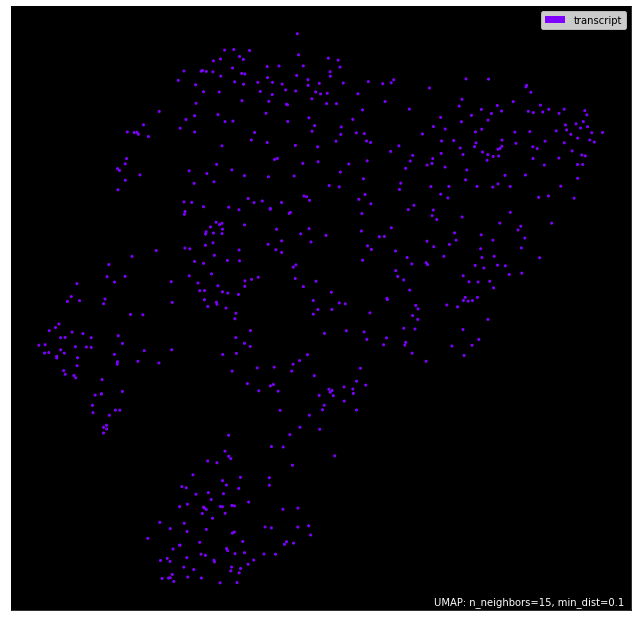

In [ ]:
import umap.plot
umap.plot.points(manifold, labels=y, theme="fire");